In [ ]:
# Analisis Sentimen Ulasan Gojek dengan Deep Learning dan Pendekatan Berbasis Teks
# Import package yang dibutuhkan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, Conv1D, GlobalMaxPooling1D, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')  # Untuk SentimentIntensityAnalyzer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:

# Set memory growth for GPU (jika menggunakan GPU)
try:
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU tersedia: {len(gpus)}")
    else:
        print("Tidak ada GPU yang terdeteksi, menggunakan CPU")
except Exception as e:
    print(f"Error dalam setup GPU: {e}")

Tidak ada GPU yang terdeteksi, menggunakan CPU


In [ ]:
# Baca dataset asli
print("Membaca dataset...")
df = pd.read_csv('/content/gojek_reviews.csv')

Membaca dataset...


In [ ]:
# Tampilkan info tentang dataset
print("\nInformasi Dataset:")
print(df.info())
print("\nContoh data:")
print(df.head())

# Cek distribusi skor
print("\nDistribusi skor:")
print(df['score'].value_counts().sort_index())


Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52430 entries, 0 to 52429
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              52430 non-null  object
 1   userName              52430 non-null  object
 2   userImage             52430 non-null  object
 3   content               52430 non-null  object
 4   score                 52430 non-null  int64 
 5   thumbsUpCount         52430 non-null  int64 
 6   reviewCreatedVersion  40562 non-null  object
 7   at                    52430 non-null  object
 8   replyContent          13869 non-null  object
 9   repliedAt             13869 non-null  object
 10  appVersion            40561 non-null  object
dtypes: int64(2), object(9)
memory usage: 4.4+ MB
None

Contoh data:
                               reviewId         userName  \
0  5a957f59-d97b-4ebb-81ba-76cbc950f80a  Pengguna Google   
1  468db741-3adc-4129-b2d5-b7e47

In [ ]:
# Fungsi untuk praproses teks
def preprocess_text(text):
    if isinstance(text, str):
        # Lowercase
        text = text.lower()
        # Hapus URL
        text = re.sub(r'http\S+', '', text)
        # Hapus mention dan hashtag
        text = re.sub(r'@\w+|#\w+', '', text)
        # Hapus karakter khusus dan angka
        text = re.sub(r'[^\w\s]|[\d]', '', text)
        # Hapus whitespace berlebih
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    return ""


In [ ]:
# CARA 1: PENDEKATAN LEXICON-BASED
# Fungsi untuk menentukan sentimen menggunakan kamus kata positif dan negatif dalam Bahasa Indonesia
def lexicon_based_sentiment(text):
    # Kamus sederhana kata positif dan negatif dalam Bahasa Indonesia
    # Kata-kata ini dapat ditambah atau diubah sesuai kebutuhan
    positive_words = [
        'bagus', 'baik', 'senang', 'suka', 'puas', 'cepat', 'enak', 'ramah',
        'recommended', 'mantap', 'keren', 'top', 'membantu', 'oke', 'ok',
        'mudah', 'nyaman', 'bersih', 'tepat', 'cepat', 'terbaik', 'rekomen',
        'memuaskan', 'tanggap', 'profesional', 'hebat', 'menyenangkan', 'luar biasa'
    ]

    negative_words = [
        'buruk', 'jelek', 'lambat', 'kecewa', 'mahal', 'susah', 'rumit', 'tidak',
        'jangan', 'batal', 'gagal', 'error', 'rugi', 'marah', 'kesal', 'sulit',
        'benci', 'parah', 'lemot', 'lama', 'kasar', 'bodoh', 'payah', 'mengecewakan',
        'menyebalkan', 'mengerikan', 'menipu', 'berbohong', 'bug', 'hang'
    ]

    words = text.lower().split()
    # Hitung kata positif dan negatif  # Indentation fixed here
    positive_count = sum(1 for word in words if word in positive_words)
    negative_count = sum(1 for word in words if word in negative_words)

In [ ]:
# CARA 2: PENDEKATAN VADER (ADAPTASI UNTUK BAHASA INDONESIA)
# Meskipun VADER dirancang untuk Bahasa Inggris, kita bisa mencoba adaptasi
# dengan menerjemahkan kata-kata kunci Bahasa Indonesia ke Inggris
def map_indo_to_eng(text):
    # Kamus sederhana kata Bahasa Indonesia ke Bahasa Inggris
    indo_to_eng = {
        'bagus': 'good', 'baik': 'good', 'senang': 'happy', 'suka': 'like',
        'puas': 'satisfied', 'cepat': 'fast', 'enak': 'nice', 'ramah': 'friendly',
        'mantap': 'great', 'keren': 'cool', 'membantu': 'helpful', 'mudah': 'easy',
        'buruk': 'bad', 'jelek': 'ugly', 'lambat': 'slow', 'kecewa': 'disappointed',
        'mahal': 'expensive', 'susah': 'difficult', 'tidak': 'not', 'batal': 'cancel',
        'gagal': 'fail', 'error': 'error', 'rugi': 'loss', 'marah': 'angry',
        'kesal': 'annoyed', 'sulit': 'difficult', 'nyaman': 'comfortable',
        'bersih': 'clean', 'kotor': 'dirty', 'terbaik': 'best', 'terburuk': 'worst'
    }

    words = text.lower().split()
    eng_words = []

    for word in words:
        if word in indo_to_eng:
            eng_words.append(indo_to_eng[word])
        else:
            eng_words.append(word)

    return ' '.join(eng_words)

def vader_sentiment(text):
    # Inisialisasi SentimentIntensityAnalyzer
    sid = SentimentIntensityAnalyzer()

    # "Terjemahkan" kata kunci ke Bahasa Inggris
    eng_text = map_indo_to_eng(text)

    # Dapatkan skor sentimen
    sentiment_scores = sid.polarity_scores(eng_text)

    # Tentukan sentimen berdasarkan skor compound
    if sentiment_scores['compound'] >= 0.05:
        return 'positif'
    elif sentiment_scores['compound'] <= -0.05:
        return 'negatif'
    else:
        return 'netral'

In [ ]:
# CARA 3: PENDEKATAN HYBRID
# Menggabungkan lexicon-based, VADER, dan rating
def hybrid_sentiment_analysis(text, score=None):
    # Dapatkan sentimen dari lexicon-based
    lexicon_result = lexicon_based_sentiment(text)

    # Dapatkan sentimen dari VADER
    vader_result = vader_sentiment(text)

    # Tentukan sentimen final berdasarkan "voting"
    if lexicon_result == vader_result:
        return lexicon_result
    elif score is not None:
        # Jika hasil berbeda, gunakan skor sebagai tie-breaker
        if score <= 2:
            return 'negatif'
        elif score >= 4:
            return 'positif'
        else:
            return 'netral'
    else:
        # Jika tidak ada skor, prioritaskan lexicon-based untuk Bahasa Indonesia
        return lexicon_result

In [ ]:
# Praproses teks
print("\nMemulai praproses teks...")
# Gunakan chunk processing untuk dataset besar
chunk_size = 50000
for i in range(0, len(df), chunk_size):
    end = min(i + chunk_size, len(df))
    print(f"  Memproses {i} sampai {end}...")
    df.loc[i:end-1, 'processed_content'] = df.loc[i:end-1, 'content'].apply(preprocess_text)


Memulai praproses teks...
  Memproses 0 sampai 50000...
  Memproses 50000 sampai 52430...


In [ ]:
# Membuat label sentimen berbasis teks (bukan hanya berbasis skor)
print("\nMembuat label sentimen berbasis teks...")
# Contoh aplikasi hybrid sentiment analysis
df['text_sentiment'] = df.apply(
    lambda row: hybrid_sentiment_analysis(row['processed_content'], row['score']),
    axis=1
)

# Konversi label sentimen ke kode
sentiment_map = {'negatif': 0, 'netral': 1, 'positif': 2}
df['sentiment_code'] = df['text_sentiment'].map(sentiment_map)


Membuat label sentimen berbasis teks...


In [ ]:
# Bandingkan label sentimen berbasis teks dengan label berbasis skor
df['score_sentiment'] = df['score'].apply(
    lambda score: 'negatif' if score <= 2 else ('netral' if score == 3 else 'positif')
)

In [ ]:
# Perbandingan hasil labeling
agreement = (df['text_sentiment'] == df['score_sentiment']).mean() * 100
print(f"\nPersentase kecocokan antara label berbasis teks dan berbasis skor: {agreement:.2f}%")



Persentase kecocokan antara label berbasis teks dan berbasis skor: 100.00%


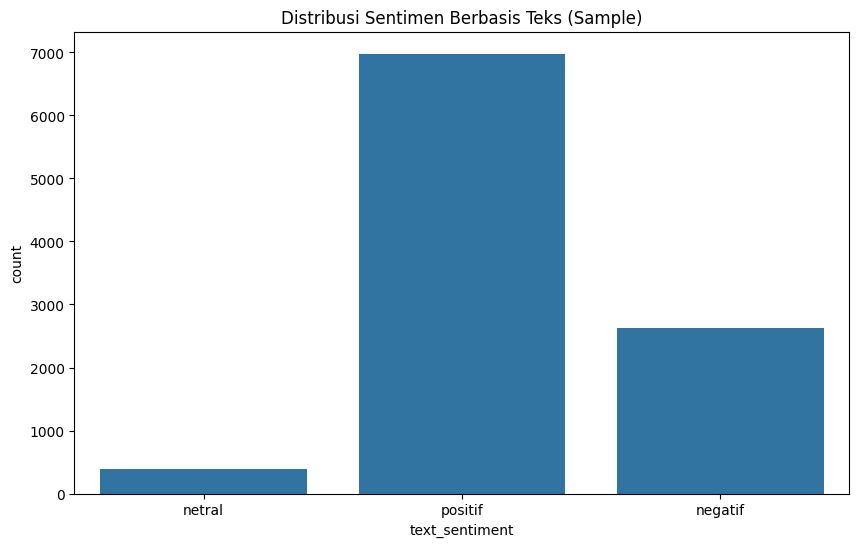

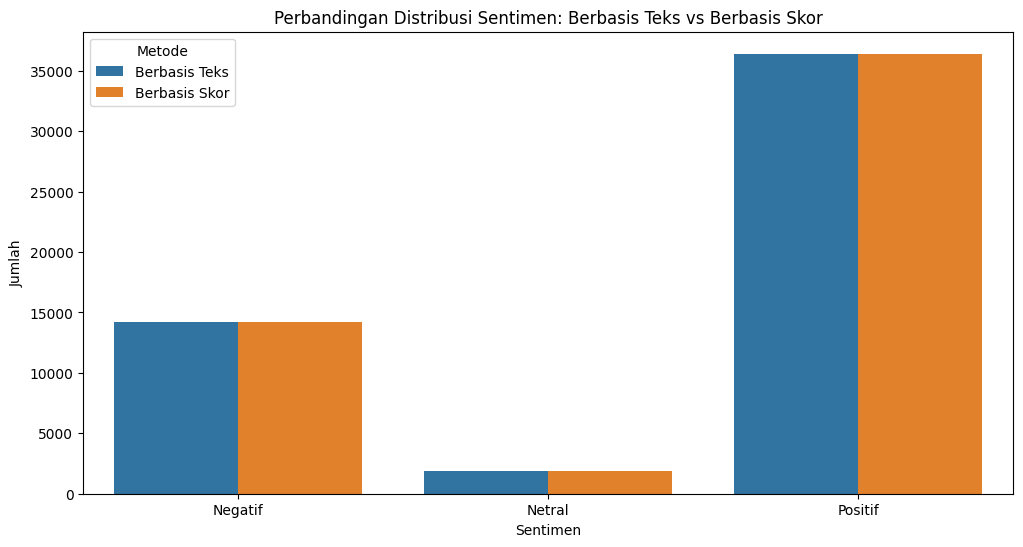


Praproses data selesai


In [ ]:
# Visualisasi distribusi sentimen berbasis teks
plt.figure(figsize=(10, 6))
sns.countplot(x='text_sentiment', data=df.sample(min(len(df), 10000), random_state=42))
plt.title('Distribusi Sentimen Berbasis Teks (Sample)')
plt.show()

# Visualisasi perbandingan sentimen berbasis teks vs berbasis skor
comparison_df = pd.DataFrame({
    'Metode': ['Berbasis Teks', 'Berbasis Skor'],
    'Negatif': [
        (df['text_sentiment'] == 'negatif').sum(),
        (df['score_sentiment'] == 'negatif').sum()
    ],
    'Netral': [
        (df['text_sentiment'] == 'netral').sum(),
        (df['score_sentiment'] == 'netral').sum()
    ],
    'Positif': [
        (df['text_sentiment'] == 'positif').sum(),
        (df['score_sentiment'] == 'positif').sum()
    ]
})

comparison_melted = pd.melt(comparison_df, id_vars=['Metode'],
                           value_vars=['Negatif', 'Netral', 'Positif'],
                           var_name='Sentimen', value_name='Jumlah')

plt.figure(figsize=(12, 6))
sns.barplot(x='Sentimen', y='Jumlah', hue='Metode', data=comparison_melted)
plt.title('Perbandingan Distribusi Sentimen: Berbasis Teks vs Berbasis Skor')
plt.show()

print("\nPraproses data selesai")

In [ ]:
# Cek distribusi panjang teks
text_lengths = df['processed_content'].str.len()
print(f"\nStatistik panjang teks:")
print(f"  Min: {text_lengths.min()}")
print(f"  Mean: {text_lengths.mean():.2f}")
print(f"  Median: {text_lengths.median()}")
print(f"  95 percentile: {text_lengths.quantile(0.95)}")
print(f"  Max: {text_lengths.max()}")

# Tentukan max_length berdasarkan persentil ke-95 atau nilai tetap
max_length = min(int(text_lengths.quantile(0.95)), 100)
print(f"Menggunakan max_length = {max_length} untuk padding")


Statistik panjang teks:
  Min: 0
  Mean: 58.10
  Median: 24.0
  95 percentile: 237.0
  Max: 500
Menggunakan max_length = 100 untuk padding


In [ ]:
# ----------------------------------
# DATA PREPARATION & TOKENIZATION
# ----------------------------------

# Ambil fitur dan target - MENGGUNAKAN SENTIMEN BERBASIS TEKS
X = df['processed_content']
y = df['sentiment_code']  # Dari text_sentiment yang sudah dikonversi ke sentiment_code

In [ ]:
# Membagi data menjadi training dan testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nUkuran data training: {len(X_train)} sampel")
print(f"Ukuran data testing: {len(X_test)} sampel")


Ukuran data training: 41944 sampel
Ukuran data testing: 10486 sampel


In [ ]:
# Tokenisasi - gunakan vocab size yang lebih besar untuk dataset besar
vocab_size = 15000
print("\nMemulai tokenisasi...")

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train)

# Simpan vocabulary size aktual
vocab_actual_size = len(tokenizer.word_index) + 1
print(f"Total kata unik dalam vocabulary: {vocab_actual_size}")


Memulai tokenisasi...
Total kata unik dalam vocabulary: 24028


In [ ]:
# Tokenisasi dan padding untuk training set
print("Tokenisasi training set...")
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')

# Tokenisasi dan padding untuk test set
print("Tokenisasi test set...")
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

Tokenisasi training set...
Tokenisasi test set...


In [ ]:
# ----------------------------------
# MODEL 1: BiLSTM dengan optimasi
# ----------------------------------

def create_bilstm_model():
    model = Sequential([
        Embedding(input_dim=min(vocab_size, vocab_actual_size),
                  output_dim=128,
                  input_length=max_length),
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.4),
        Bidirectional(LSTM(32)),
        Dropout(0.4),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(3, activation='softmax')
    ])

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    return model

print("\n--- MODEL 1: BiLSTM dengan Embedding ---")
model1 = create_bilstm_model()
print(model1.summary())


--- MODEL 1: BiLSTM dengan Embedding ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# Callbacks dengan lebih banyak opsi
callbacks = [
    EarlyStopping(monitor='val_accuracy',
                  patience=3,
                  restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss',
                      factor=0.5,
                      patience=2,
                      min_lr=0.0001),
    ModelCheckpoint('best_model1.h5',
                    monitor='val_accuracy',
                    save_best_only=True)
]

In [ ]:
# Training model 1 dengan batch size yang lebih besar
batch_size = 64
print(f"\nMemulai training Model 1 dengan batch size {batch_size}...")

history1 = model1.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=batch_size,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1
)


Memulai training Model 1 dengan batch size 64...
Epoch 1/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.8311 - loss: 0.4664

590/590 ━━━━━━━━━━━━━━━━━━━━ 266s 429ms/step - accuracy: 0.8312 - loss: 0.4662 - val_accuracy: 0.9061 - val_loss: 0.2804 - learning_rate: 0.0010
Epoch 2/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 259s 425ms/step - accuracy: 0.9164 - loss: 0.2779 - val_accuracy: 0.9030 - val_loss: 0.2950 - learning_rate: 0.0010
Epoch 3/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 262s 425ms/step - accuracy: 0.9288 - loss: 0.2284 - val_accuracy: 0.9042 - val_loss: 0.2956 - learning_rate: 0.0010
Epoch 4/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 260s 421ms/step - accuracy: 0.9414 - loss: 0.1841 - val_accuracy: 0.8980 - val_loss: 0.3438 - learning_rate: 5.0000e-04


In [ ]:
# Evaluasi model 1
print("\nEvaluasi Model 1 pada test set...")
loss1, accuracy1 = model1.evaluate(X_test_pad, y_test, batch_size=batch_size)
print(f"Model 1 - Test Accuracy: {accuracy1*100:.2f}%")




Evaluasi Model 1 pada test set...
164/164 ━━━━━━━━━━━━━━━━━━━━ 18s 107ms/step - accuracy: 0.9038 - loss: 0.2991
Model 1 - Test Accuracy: 90.16%


In [ ]:
# Prediksi dan evaluasi lanjutan
y_pred1 = model1.predict(X_test_pad, batch_size=batch_size)
y_pred_classes1 = np.argmax(y_pred1, axis=1)

print("Classification Report - Model 1:")
cr1 = classification_report(y_test, y_pred_classes1, target_names=['negatif', 'netral', 'positif'])
print(cr1)

164/164 ━━━━━━━━━━━━━━━━━━━━ 19s 112ms/step
Classification Report - Model 1:
              precision    recall  f1-score   support

     negatif       0.79      0.92      0.85      2835
      netral       0.00      0.00      0.00       371
     positif       0.95      0.94      0.95      7280

    accuracy                           0.90     10486
   macro avg       0.58      0.62      0.60     10486
weighted avg       0.88      0.90      0.89     10486



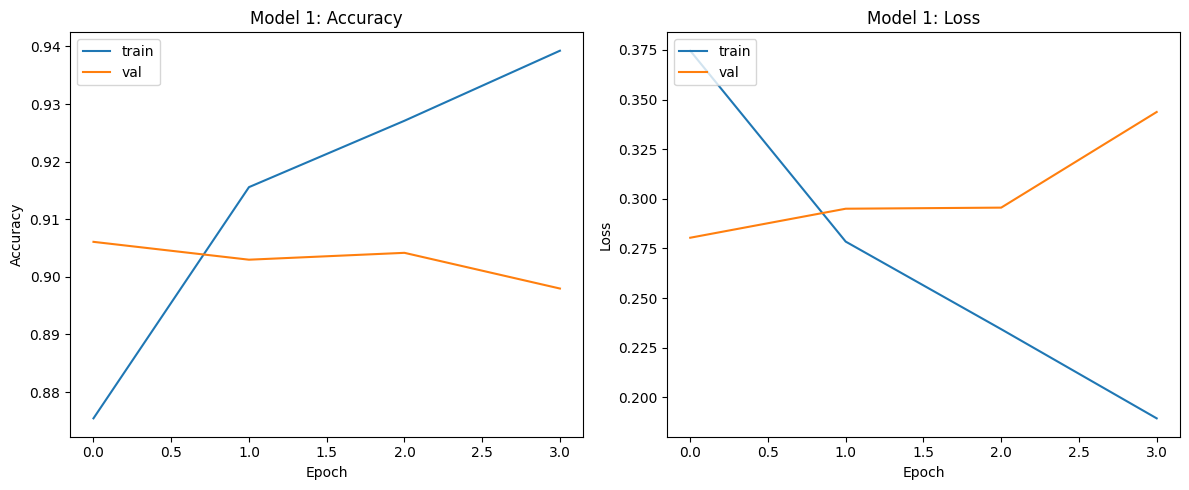

In [ ]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model 1: Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model 1: Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# ----------------------------------
# MODEL 2: CNN + Global Max Pooling
# ----------------------------------

def create_cnn_model():
    model = Sequential([
        Embedding(input_dim=min(vocab_size, vocab_actual_size),
                  output_dim=128,
                  input_length=max_length),
        Conv1D(128, 5, padding='same', activation='relu'),
        Conv1D(128, 3, padding='same', activation='relu'),
        GlobalMaxPooling1D(),
        Dense(64, activation='relu'),
        Dropout(0.4),
        Dense(3, activation='softmax')
    ])

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    return model

print("\n--- MODEL 2: CNN dengan Global Max Pooling ---")
model2 = create_cnn_model()
print(model2.summary())


--- MODEL 2: CNN dengan Global Max Pooling ---


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# Training model 2
print(f"\nMemulai training Model 2 dengan batch size {batch_size}...")
history2 = model2.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=batch_size,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1
)


Memulai training Model 2 dengan batch size 64...
Epoch 1/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 114s 193ms/step - accuracy: 0.9215 - loss: 0.2474 - val_accuracy: 0.9051 - val_loss: 0.2880 - learning_rate: 5.0000e-04
Epoch 2/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 94s 159ms/step - accuracy: 0.9366 - loss: 0.2021 - val_accuracy: 0.9011 - val_loss: 0.3027 - learning_rate: 5.0000e-04
Epoch 3/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 93s 158ms/step - accuracy: 0.9470 - loss: 0.1595 - val_accuracy: 0.8961 - val_loss: 0.3400 - learning_rate: 5.0000e-04
Epoch 4/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 144s 162ms/step - accuracy: 0.9601 - loss: 0.1251 - val_accuracy: 0.8884 - val_loss: 0.4163 - learning_rate: 2.5000e-04


In [ ]:
# Evaluasi model 2
print("\nEvaluasi Model 2 pada test set...")
loss2, accuracy2 = model2.evaluate(X_test_pad, y_test, batch_size=batch_size)
print(f"Model 2 - Test Accuracy: {accuracy2*100:.2f}%")


Evaluasi Model 2 pada test set...
164/164 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - accuracy: 0.9039 - loss: 0.3101
Model 2 - Test Accuracy: 90.26%


In [ ]:
# Prediksi dan evaluasi lanjutan
y_pred2 = model2.predict(X_test_pad, batch_size=batch_size)
y_pred_classes2 = np.argmax(y_pred2, axis=1)

print("Classification Report - Model 2:")
cr2 = classification_report(y_test, y_pred_classes2, target_names=['negatif', 'netral', 'positif'])
print(cr2)

164/164 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step
Classification Report - Model 2:
              precision    recall  f1-score   support

     negatif       0.78      0.94      0.85      2835
      netral       0.00      0.00      0.00       371
     positif       0.96      0.93      0.95      7280

    accuracy                           0.90     10486
   macro avg       0.58      0.63      0.60     10486
weighted avg       0.88      0.90      0.89     10486



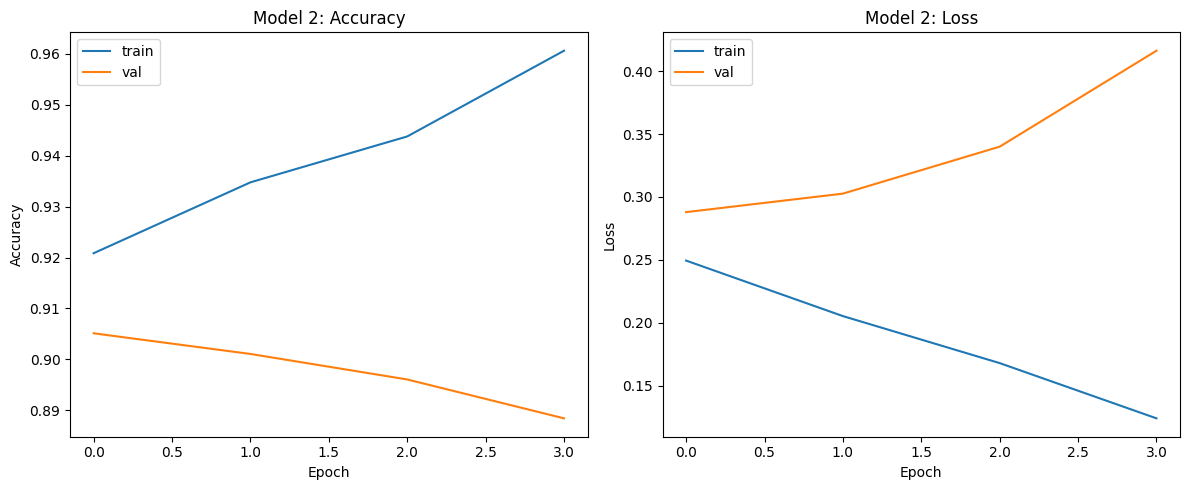

In [ ]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model 2: Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model 2: Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# ----------------------------------
# MODEL 3: Hybrid CNN-LSTM
# ----------------------------------

def create_cnn_lstm_model():
    model = Sequential([
        Embedding(input_dim=min(vocab_size, vocab_actual_size),
                  output_dim=128,
                  input_length=max_length),
        Conv1D(128, 3, padding='same', activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(64, return_sequences=False),
        Dropout(0.4),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(3, activation='softmax')
    ])

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    return model

print("\n--- MODEL 3: Hybrid CNN-LSTM ---")
model3 = create_cnn_lstm_model()
print(model3.summary())


--- MODEL 3: Hybrid CNN-LSTM ---


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# Training model 3
print(f"\nMemulai training Model 3 dengan batch size {batch_size}...")
history3 = model3.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=batch_size,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1
)


Memulai training Model 3 dengan batch size 64...
Epoch 1/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 89s 142ms/step - accuracy: 0.7446 - loss: 0.6357 - val_accuracy: 0.7039 - val_loss: 0.7034 - learning_rate: 0.0010
Epoch 2/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 84s 143ms/step - accuracy: 0.6941 - loss: 0.7338 - val_accuracy: 0.7039 - val_loss: 0.7187 - learning_rate: 0.0010
Epoch 3/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 144s 146ms/step - accuracy: 0.6912 - loss: 0.7409 - val_accuracy: 0.7039 - val_loss: 0.7176 - learning_rate: 0.0010
Epoch 4/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 144s 149ms/step - accuracy: 0.6955 - loss: 0.7302 - val_accuracy: 0.7039 - val_loss: 0.7164 - learning_rate: 5.0000e-04


In [ ]:
# Evaluasi model 3
print("\nEvaluasi Model 3 pada test set...")
loss3, accuracy3 = model3.evaluate(X_test_pad, y_test, batch_size=batch_size)
print(f"Model 3 - Test Accuracy: {accuracy3*100:.2f}%")


Evaluasi Model 3 pada test set...
164/164 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - accuracy: 0.6903 - loss: 0.7150
Model 3 - Test Accuracy: 69.43%


In [ ]:
# Prediksi dan evaluasi lanjutan
y_pred3 = model3.predict(X_test_pad, batch_size=batch_size)
y_pred_classes3 = np.argmax(y_pred3, axis=1)

print("Classification Report - Model 3:")
cr3 = classification_report(y_test, y_pred_classes3, target_names=['negatif', 'netral', 'positif'])
print(cr3)

164/164 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step
Classification Report - Model 3:
              precision    recall  f1-score   support

     negatif       0.00      0.00      0.00      2835
      netral       0.00      0.00      0.00       371
     positif       0.69      1.00      0.82      7280

    accuracy                           0.69     10486
   macro avg       0.23      0.33      0.27     10486
weighted avg       0.48      0.69      0.57     10486



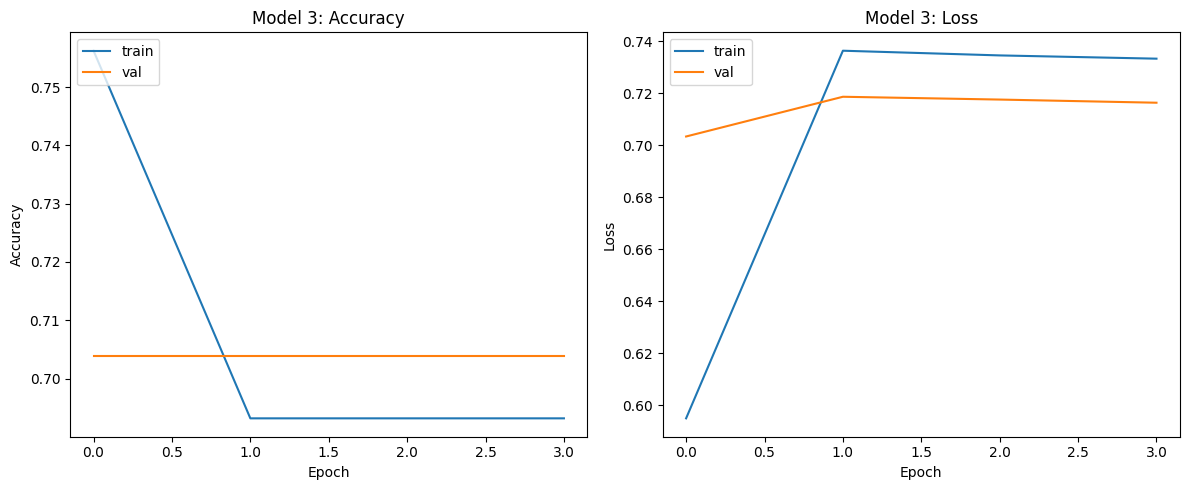

In [ ]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model 3: Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model 3: Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# ----------------------------------
# Perbandingan Ketiga Model
# ----------------------------------
print("\n--- Perbandingan Akurasi Ketiga Model ---")
comparison = pd.DataFrame({
    'Model': ['BiLSTM', 'CNN', 'CNN-LSTM'],
    'Akurasi Training': [
        history1.history['accuracy'][-1]*100,
        history2.history['accuracy'][-1]*100,
        history3.history['accuracy'][-1]*100
    ],
    'Akurasi Testing': [
        accuracy1*100,
        accuracy2*100,
        accuracy3*100
    ]
})
print(comparison)


--- Perbandingan Akurasi Ketiga Model ---
      Model  Akurasi Training  Akurasi Testing
0    BiLSTM         93.925667        90.158308
1       CNN         96.058172        90.263206
2  CNN-LSTM         69.318390        69.425899


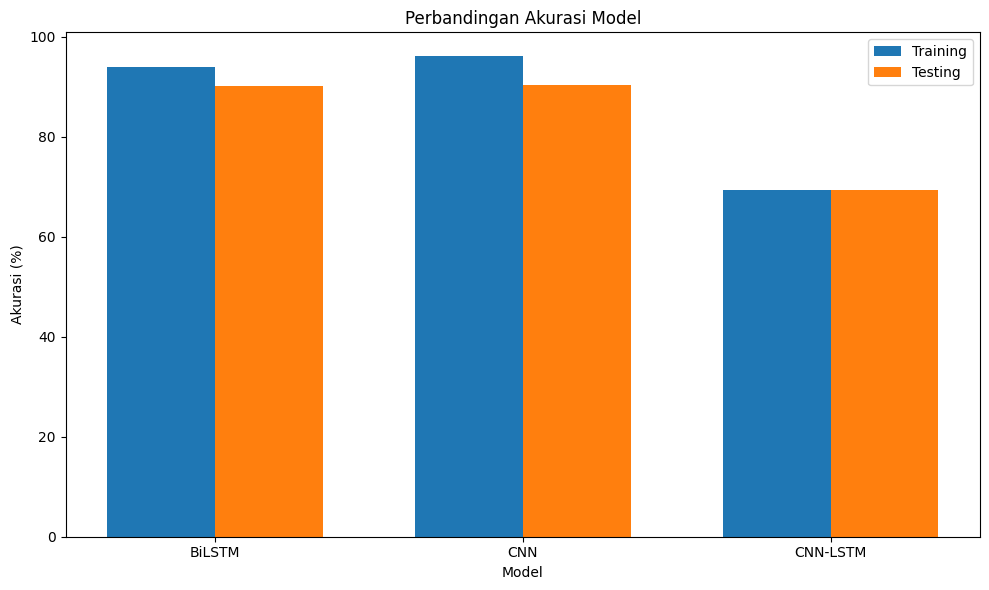

In [ ]:
# Plot perbandingan
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(3)

plt.bar(index, comparison['Akurasi Training'], bar_width, label='Training')
plt.bar(index + bar_width, comparison['Akurasi Testing'], bar_width, label='Testing')

plt.xlabel('Model')
plt.ylabel('Akurasi (%)')
plt.title('Perbandingan Akurasi Model')
plt.xticks(index + bar_width/2, comparison['Model'])
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# ----------------------------------
# Fungsi Inferensi untuk Model Terbaik
# ----------------------------------
def predict_sentiment(text, model, tokenizer):
    # Praproses teks
    processed_text = preprocess_text(text)

    # Tokenisasi dan padding
    sequence = tokenizer.texts_to_sequences([processed_text])
    padded = pad_sequences(sequence, maxlen=max_length, padding='post')

    # Prediksi
    prediction = model.predict(padded)[0]
    predicted_class = np.argmax(prediction)

    # Mengkonversi kembali ke label sentimen
    sentiments = {0: 'negatif', 1: 'netral', 2: 'positif'}
    sentiment = sentiments[predicted_class]

    confidence = prediction[predicted_class] * 100

    return {
        'text': text,
        'processed': processed_text,
        'sentiment': sentiment,
        'confidence': confidence,
        'probabilities': {
            'negatif': prediction[0] * 100,
            'netral': prediction[1] * 100,
            'positif': prediction[2] * 100
        }
    }

In [ ]:
# Cari model dengan akurasi terbaik
best_accuracy = max(accuracy1, accuracy2, accuracy3)
if best_accuracy == accuracy1:
    best_model = model1
    best_tokenizer = tokenizer
    model_name = "BiLSTM"
elif best_accuracy == accuracy2:
    best_model = model2
    best_tokenizer = tokenizer
    model_name = "CNN"
else:
    best_model = model3
    best_tokenizer = tokenizer
    model_name = "CNN-LSTM"

print(f"\nModel terbaik adalah {model_name} dengan akurasi {best_accuracy*100:.2f}%")


Model terbaik adalah CNN dengan akurasi 90.26%


In [ ]:
# ----------------------------------
# Uji inferensi dengan beberapa contoh
# ----------------------------------
test_examples = [
    "Aplikasi bagus, sangat membantu aktivitas sehari-hari",
    "Aplikasi ini seringkali error dan membuat saya kecewa",
    "Biasa saja, tidak ada yang spesial",
    "Tolong diperbaiki lagi fiturnya, masih banyak bug",
    "Layanan pengirimannya cepat sekali, terimakasih gojek!"
]

print("\n--- Hasil Inferensi dengan Model Terbaik ---")
for text in test_examples:
    result = predict_sentiment(text, best_model, best_tokenizer)
    print(f"Teks: {result['text']}")
    print(f"Sentimen: {result['sentiment']} (confidence: {result['confidence']:.2f}%)")
    print(f"Probabilitas: Negatif={result['probabilities']['negatif']:.2f}%, Netral={result['probabilities']['netral']:.2f}%, Positif={result['probabilities']['positif']:.2f}%")
    print("-" * 50)


--- Hasil Inferensi dengan Model Terbaik ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Teks: Aplikasi bagus, sangat membantu aktivitas sehari-hari
Sentimen: positif (confidence: 99.86%)
Probabilitas: Negatif=0.08%, Netral=0.07%, Positif=99.86%
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Teks: Aplikasi ini seringkali error dan membuat saya kecewa
Sentimen: negatif (confidence: 80.56%)
Probabilitas: Negatif=80.56%, Netral=6.32%, Positif=13.12%
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Teks: Biasa saja, tidak ada yang spesial
Sentimen: negatif (confidence: 85.95%)
Probabilitas: Negatif=85.95%, Netral=6.25%, Positif=7.80%
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Teks: Tolong diperbaiki lagi fiturnya, masih banyak bug
Sentimen: negatif (confidence: 46.76%)
Probabilitas: Negatif=46.76%, Netral=8.67%, Positif=44.57%
------------------------------------------

In [ ]:
# Inferensi untuk beberapa sampel dari dataset asli
random_samples = df.sample(5)
print("\n--- Inferensi Sampel dari Dataset Asli ---")
for idx, row in random_samples.iterrows():
    original_text = row['content']
    original_sentiment = row['text_sentiment']  # Menggunakan sentimen berbasis teks
    result = predict_sentiment(original_text, best_model, best_tokenizer)

    print(f"ID Review: {row['reviewId'] if 'reviewId' in row else idx}")
    print(f"Teks Asli: {original_text}")
    print(f"Skor: {row['score']}")
    print(f"Sentimen (Berbasis Teks): {original_sentiment}")
    print(f"Sentimen Prediksi: {result['sentiment']} (confidence: {result['confidence']:.2f}%)")
    print("-" * 50)


--- Inferensi Sampel dari Dataset Asli ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
ID Review: 33c79f83-efa6-4cbc-a39d-ed457bc528bd
Teks Asli: turunkan harga ongkir
Skor: 1
Sentimen (Berbasis Teks): negatif
Sentimen Prediksi: negatif (confidence: 79.48%)
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
ID Review: c51088d4-c286-4045-b0ae-b298d66f7a23
Teks Asli: Aplikasi yg tidak manusiawi terhadap drivernya sendiri
Skor: 1
Sentimen (Berbasis Teks): negatif
Sentimen Prediksi: negatif (confidence: 94.94%)
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
ID Review: bbff9075-9695-4999-b3ec-558b9b06cc2e
Teks Asli: Keren
Skor: 5
Sentimen (Berbasis Teks): positif
Sentimen Prediksi: positif (confidence: 99.62%)
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
ID Review: 26a003cd-c87e-4217-9b96-bd017515ae30
Teks Asli: Gojek cakep
Skor: 5
Sentimen (Berbasis Teks): positif
Senti

In [ ]:
# Simpan model terbaik dan tokenizer
print(f"\nMenyimpan model terbaik ({model_name})...")
best_model.save(f'best_sentiment_model_{model_name}.h5')



Menyimpan model terbaik (CNN)...


In [ ]:
# Simpan tokenizer untuk penggunaan di masa depan
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

print(f"Model terbaik telah disimpan sebagai 'best_sentiment_model_{model_name}.h5'")
print(f"Tokenizer telah disimpan sebagai 'tokenizer.pickle'")

Model terbaik telah disimpan sebagai 'best_sentiment_model_CNN.h5'
Tokenizer telah disimpan sebagai 'tokenizer.pickle'


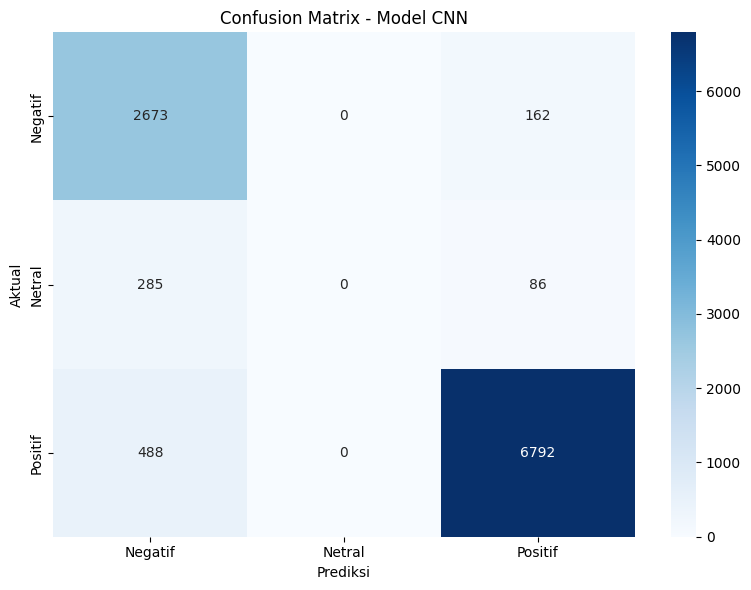


Analisis Sentimen selesai!


In [ ]:
# Visualisasi confusion matrix untuk model terbaik
if best_accuracy == accuracy1:
    y_pred_classes = y_pred_classes1
elif best_accuracy == accuracy2:
    y_pred_classes = y_pred_classes2
else:
    y_pred_classes = y_pred_classes3

cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negatif', 'Netral', 'Positif'],
            yticklabels=['Negatif', 'Netral', 'Positif'])
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title(f'Confusion Matrix - Model {model_name}')
plt.tight_layout()
plt.show()  # Tampilkan langsung di Colab

print("\nAnalisis Sentimen selesai!")